In [2]:
import numpy as np
import requests
import pandas as pd
import time
import re
import string
import nltk
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer

# The problem statement
Modern investing was reinvented last year when a few unknown _civilian_ investors became millionaires and sharing their ideas with the world on the social media platform Reddit. Since then, the subreddit that was made famous has become a bloated and cartoonish version of its former self (which wasn't that great to begin with). 

The problem therefore is, if you, an individual investor (read: non-professional), are looking for your next investment idea or thesis by reading investment news on reddit, you should have guideline as to the provenance of that newsbite. 

This model will attempt to distinguish if a post has come from r/WallStreetBets _(WSB)_, where snake oil and otherwise imprudent investment ideas lurk in the shadow. OR the post comes from a more (or less) sober subreddit r/stocks _(STK)_.
I will use a machine learning to process the text using Natural Language Processing techniques to convert the text into something a predictive model can understand. After that I hope to be able to present our algorithm new text streams and have the algorithm determine where it came from.  

This can be useful to help investors determine if further diligence on an idea is worth the time and energy or not. There is no shortage of stories of copy-cat investors that lost everything during this mini gold rush. 



The notebook and project has the following structure:
Notebook:
1. Data collection, Cleaning, and EDA.
2. Modeling/Model Tuning. 
3. Predictions. 

## Functions. 
In this section I will take in data from Reddit via the pushshift.io api. 

In the following three cells I define the functions that will call to pushshift api and pull data from our target subreddits; r/wallstreetbets and r/stocks.

`get_data_now` is a function that acts as our main calling function. Our initial arguments passed to the api are the subreddit titles and the size of each subreddit pull request. This function will return a completed dataframe conforming to the size requested. 

`assembler` is a function that is used by the `get_data_now` function and by the third function `backfill` to put together a dataframe created from a list of dictionaries passed to it. Once the dataframe is created a few _regular expressions_ and _lambda functions_ are applied to it that operate as a prescrubbing. 

The _prescrubbing_is done to parse over the `title` and `selftext` columns of the resulting dataframe. Part of my requirement to answer the problem statement is to only train and test on rows that contain data from these subreddits so I can have hopefully a model that generalizes to more entries that may not have the `selftext` component. 

`backfill` This function will operate as a recursive function that will resolve imbalences between the size requested and the actual pre-scrubbed size of the resulting dataframe. 

`get_contractions` is a function made to expand on contractions used in social media posts. should help our lemmatizer do an accurate job at getting the words out. 

In [4]:
def get_data_now(sub1, sub2, size):
    '''
    This function accepts two strings as arguments and uses these strings as parameters to retrieve text from Reddit and returns a dataframe. 
    '''
    url = 'https://api.pushshift.io/reddit/search/submission'
    
    # innit counters
    counter = 0
    nan_deficit = 0 #updates and passed back from assembler function, number to be added back to size. 
    master = []
    size1 = size
    size2 = size
    timer = time.sleep(3)
    
    #sub1 collection#
    #first call to api 
    
    params = {'subreddit': sub1,'size': 100, 'fields' : ['subreddit', 'title', 'selftext', 'created_utc']}
    res = requests.get(url, params)
    posts = res.json()['data']
    size1 -= 100
    print(f'Starting sub r-{sub1} api calls for {size} rows.')
    for i in posts:
        master.append(i)

    
    # size calculations determines batch numbers. 
    size_fl = size1 // 100 #number of times to fetch 100 entries.
    size_mod = size1%100     #remaining number of entries to be fetched.     
    
    
    #batch calls to api
    for i in range(0, size_fl):
        
        params_batch = {'subreddit': sub1, 'size': 100, 'fields' : ['subreddit', 'title', 'selftext', 'created_utc'], 'before' : master[-1]['created_utc']}
        res_batch = requests.get(url, params_batch)
        posts_batch = res_batch.json()['data']
        for i in posts_batch:
            master.append(i)
        #manners!
        time.sleep(2)
    if size_mod > 0:
        params_batch = {'subreddit': sub1, 'size': size_mod, 'fields' : ['subreddit', 'title', 'selftext', 'created_utc'], 'before' : master[-1]['created_utc']}
        res_batch = requests.get(url, params_batch)
        posts_batch = res_batch.json()['data']
        for i in posts_batch:
            master.append(i)
    
    df_out1 = assembler(master)
    
    #fill empty rows
    if len(df_out1) != size:
        time.sleep(2)
        timez = master[-1]['created_utc']
        size_to_fill= size - len(df_out1)
        df_new = backfill(sub1, size_to_fill,timez)
    
    #appends backfilled df's
    df_out1 = df_out1.append(df_new, ignore_index = True)
    print(f'End of collection for sub r-{sub1}')    
    ##end sub1 collection
    
    
    ##sub2 collection
    
    master2 = []
    #first call to api 
    params = {'subreddit': sub2,'size': 100, 'fields' : ['subreddit', 'title', 'selftext', 'created_utc']}
    res = requests.get(url, params)
    posts = res.json()['data']
    size2 -= 100
    print(f'Starting sub r-{sub2} api calls for {size} rows.')
    for i in posts:
        master2.append(i)
    
    # size calculations determines batch numbers. 
    size_fl2 = size2 // 100 #number of times to fetch 100 entries.
    size_mod2 = size2%100     #remaining number of entries to be fetched.     

    
    #batch calls to api
    for i in range(0, size_fl2):
        params_batch = {'subreddit': sub2, 'size': 100, 'fields' : ['subreddit', 'title', 'selftext', 'created_utc'], 'before' : master2[-1]['created_utc']}
        res_batch = requests.get(url, params_batch)
        posts_batch = res_batch.json()['data']
        for i in posts_batch:
            master2.append(i)
        #manners!!
        time.sleep(2)
    
    #assemble the dataframe, preprocess sub2, use recursion to fill empties. 
    df_out2 = assembler(master2)
    
    if len(df_out2) != size2:
        time.sleep(2)
        timez = master2[-1]['created_utc']
        size_to_fill= size - len(df_out2)
        df_new2 = backfill(sub2, size_to_fill,timez)
    
    #appends backfilled df's
    df_out2 = df_out2.append(df_new2, ignore_index = True)
    
    #append both df1 and df2
    df_out_3 = df_out1.append(df_out2, ignore_index = True)
    print(f'End of collection for sub r-{sub2}')
    print('Data collection is completed.')
     # #selftext is a description. , subreddit is y.
    return df_out_3

In [5]:
def assembler(master):
    '''
    Accepts list of dictionaries from get data to construct dataframe and process preliminary clean. 
    passes dataframe back to caller.
    '''
    #assembles a dataframe
    df = pd.DataFrame(master)[['subreddit', 'title', 'selftext', 'created_utc']]
    
    
    #cleans selftext and titles to avoid having web addresses and other strange reddit post noise.
    #This prepares the dataset for tokenization and further pipeline. 
    df['selftext'] = df['selftext'].replace('http\S+', '', regex=True).replace('www\S+', '', regex=True).replace('\n\n\S+', '', regex=True).replace('\[', '', regex=True).replace('\n|S+', '', regex = True).replace('\\|S+', '', regex = True).replace('/n|S+', '', regex = True).replace('/|S+', '', regex = True).replace("[\n\r]+", "", regex = True)
    df['title'] = df['title'].replace('http\S+', '', regex=True).replace('www\S+', '', regex=True).replace('\n\n\S+', '', regex=True).replace('\[', '', regex=True).replace('\n|S+', '', regex = True).replace('\\|S+', '', regex = True).replace('/n|S+', '', regex = True).replace('/|S+', '', regex = True).replace("[\n\r]+", "", regex = True)
    
    #removes digits
    df['selftext'] = df['selftext'].replace('\w*\d\w*','', regex=True)
    df['title'] = df['title'].replace('\w*\d\w*','', regex = True)
    
    #removes punctuation. 
    df['selftext'] = df['selftext'].replace('[%s]' % re.escape(string.punctuation), '', regex = True)
    df['title'] = df['title'].replace('[%s]' % re.escape(string.punctuation), '', regex = True)

    
    #the following applies np.nan transformations to easily remove nan data.
    df['selftext'] = df['selftext'].apply(lambda x: np.nan if x == '' else x)
    df['title'] = df['title'].apply(lambda x: np.nan if x == '' else x)
    df['selftext'] = df['selftext'].apply(lambda x: np.nan if x == '[removed]' else x)
    df['selftext'] = df['selftext'].apply(lambda x: np.nan if x == 'removed]' else x)
    df['selftext'] = df['selftext'].apply(lambda x: np.nan if x == 'removed' else x)
    df['selftext'] = df['selftext'].apply(lambda x: np.nan if x == '[deleted]' else x)
    df['selftext'] = df['selftext'].apply(lambda x: np.nan if x == 'deleted]' else x)
    df['selftext'] = df['selftext'].apply(lambda x: np.nan if x == 'deleted' else x)
    
    df = df.dropna() # drop NaN's from set. 
    
    #transforms to lower case text
    df['selftext'] = df['selftext'].apply(lambda x: x.lower())
    df['title'] = df['title'].apply(lambda x: x.lower())
    
    
    
    
    #print(f'the size of the df after drop is {len(df)}') #statement used in testing is off for production.
    
    return df

In [6]:
def backfill(sub, size, filltime):
    '''
    accepts three parameters, sub for subreddit to be filled, size for size to be filled by api, time the last time called by the calling function.
    '''
    url = 'https://api.pushshift.io/reddit/search/submission'
    
    
    print(f'new backfill call to fill {size} empty cells for sub {sub}') #statement used in testing is off for production.
    
    #intiialize list#
    to_fill_master = []
    timer = time.sleep(2)
    size_remaining = size
    
    #initialize variables for size#
    if size_remaining < 100:
        params = {'subreddit': sub,'size': size_remaining, 'fields' : ['subreddit', 'title', 'selftext', 'created_utc'], 'before' : filltime}
        res = requests.get(url, params)
        
        #print(f'Less than 100 called to API, response {res.status_code}')#statement used in testing is off for production.
        
        posts = res.json()['data']
        for i in posts:
            to_fill_master.append(i)
        df_a1 = assembler(to_fill_master)
        if len(df_a1) != size:
            time.sleep(2)
            timez = to_fill_master[-1]['created_utc']
            size_to_fill= size - len(df_a1)
            df_new = backfill(sub, size_to_fill,timez)
            df_a1 = df_a1.append(df_new, ignore_index = True)
        return df_a1
        #else:
         #   return df_a1
        
    if size > 100:
        #first call
        params = {'subreddit': sub,'size': 100, 'fields' : ['subreddit', 'title', 'selftext', 'created_utc'], 'before' : filltime}
        res = requests.get(url, params)
        
        #print(f'100 first call results called to API, response {res.status_code}') #statement used in testing is off for production.
        
        posts = res.json()['data']
        size_remaining -= 100
        for i in posts:
            to_fill_master.append(i)
        time.sleep(2)

        
        size_fl = size_remaining // 100 
        size_mod = size_remaining%100
         #first floor, then modulus#
        for i in range(0, size_fl):
            #run for size = 100 n-times. 
            params_batch = {'subreddit': sub, 'size': 100, 'fields' : ['subreddit', 'title', 'selftext', 'created_utc'], 'before' : to_fill_master[-1]['created_utc']}
            res_batch = requests.get(url, params_batch)
            
            #print(f'100 floor results called to API, response {res_batch.status_code}')#statement used in testing is off for production.
            
            posts_batch = res_batch.json()['data']
            for i in posts_batch:
                to_fill_master.append(i)
            #manners!
            time.sleep(2)
        
        if size_mod > 0:
            params_batch = {'subreddit': sub, 'size': size_mod, 'fields' : ['subreddit', 'title', 'selftext', 'created_utc'], 'before' : to_fill_master[-1]['created_utc']}
            res_batch = requests.get(url, params_batch)
            
            #print(f'Modulo size {size_mod} results called to API, response {res_batch.status_code}')#statement used in testing is off for production.
            
            posts_batch = res_batch.json()['data']
            for i in posts_batch:
                to_fill_master.append(i)
        
        df_a2 = assembler(to_fill_master)
        
        if len(df_a2) != size:
            timez = to_fill_master[-1]['created_utc']
            size_to_fill= size - len(df_a2)
            df_new2 = backfill(sub, size_to_fill,timez)
            df_a2 = df_a2.append(df_new2, ignore_index = True)
        return df_a2
        #else:
         #   return df_a2

# Calling API and receiving data
---
Here we will call the `get_data_now` function and pass our two target subreddits `r/wallstreetbets` and `r/stocks`. We will fetch 25,000 rows of each subreddit before our EDA process.  

In [6]:
#This cell will take a while to complete. 
#When complete we will see 'Data collection is completed.'
reddit25 = get_data_now('wallstreetbets','stocks', 25_000)

Starting sub r-wallstreetbets api calls for 25000 rows.
new backfill call to fill 19414 empty cells for sub wallstreetbets
new backfill call to fill 14957 empty cells for sub wallstreetbets
new backfill call to fill 10957 empty cells for sub wallstreetbets
new backfill call to fill 8253 empty cells for sub wallstreetbets
new backfill call to fill 5936 empty cells for sub wallstreetbets
new backfill call to fill 4308 empty cells for sub wallstreetbets
new backfill call to fill 3170 empty cells for sub wallstreetbets
new backfill call to fill 2366 empty cells for sub wallstreetbets
new backfill call to fill 1761 empty cells for sub wallstreetbets
new backfill call to fill 1305 empty cells for sub wallstreetbets
new backfill call to fill 944 empty cells for sub wallstreetbets
new backfill call to fill 701 empty cells for sub wallstreetbets
new backfill call to fill 518 empty cells for sub wallstreetbets
new backfill call to fill 365 empty cells for sub wallstreetbets
new backfill call to 

In [7]:
len(reddit25)

50000

Get a copy of the long awaited output saved down. Then make a working copy of the dataframe. 

In [8]:
reddit25.to_csv('./data/reddit25k.csv', index = False)

In [3]:
#incase we need to reset the analysis and start fresh. read in the reddit as df1
reddit25 = pd.read_csv('../data/reddit25k.csv')

In [4]:
df1 = reddit25.copy()

# Cleaning

---
The `assembler` function took care of a number of different processes. The data should be clean enough for our purposes and ready to tokenize. We will still look to review for any blank or NaN values that made it through the function.  

In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   subreddit    50000 non-null  object
 1   title        50000 non-null  object
 2   selftext     50000 non-null  object
 3   created_utc  50000 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.5+ MB


I explicitly cleaned out `'[removed]'` and `'[deleted]'` from the dataset in the data ingestion phase. Below we will see how many rows contain the character `'['` in the text string. 

In [6]:
df1[df1['selftext'].str.contains('deleted')].sum()

subreddit      wallstreetbetswallstreetbetswallstreetbetswall...
title          im just here for the header imagehpe ape analy...
selftext       whats the sauce my first post got deleted for ...
created_utc                                         335110503143
dtype: object

In [7]:
df1[df1['selftext'].str.contains('removed')]

,subreddit,title,selftext,created_utc
264,wallstreetbets,hello fellow apes i have a few questions for r...,okay so basically lets start this of right am ...,1635890330
582,wallstreetbets,wb rules please read before posting,welcome to wb reading what in the world is wa...,1635746424
808,wallstreetbets,grab the inevitable play,grab the inevitable bagger first submission ...,1635628276
823,wallstreetbets,idk anything need help,i dont know shit about stocks i got like to m...,1635621218
990,wallstreetbets,elon musk supports psychedelic will this affec...,“i think generally people should be open to ps...,1635533869
...,...,...,...,...
49199,stocks,hopify removes donald trumps tores what do inv...,o hopify today removed donald trumps stores fr...,1610056442
49230,stocks,broker removed promoted etfs,hi there my online broker flatex removed some...,1610047494
49299,stocks,todays premarket movers amp news thursday janu...,good morning traders and investors of the rsto...,1610026308
49676,stocks,uggestions about my growth portfolio,ranked by portfolio composition nio enph p...,1609809632


The above shows that there are many rows containing the catch words `'removed'` and `'deleted'`. However, none of these rows is without text or has been moderated out of the reddit sub. This is ideal since we get to keep these rows of text.

In [8]:
df1[df1['selftext'] == ''].sum()

subreddit      0.0
title          0.0
selftext       0.0
created_utc    0.0
dtype: float64

In [9]:
df1.head()


,subreddit,title,selftext,created_utc
0,wallstreetbets,help,i just sold my car for i wanna know if can do...,1635955282
1,wallstreetbets,hyzn preparing for a squeeze…,hyzn still yet to recover from the weak short ...,1635955250
2,wallstreetbets,all in on meta,cut to the chase i’m all in on meta here is ...,1635955106
3,wallstreetbets,camping world holdings moon discussion,beat on both the top and bottom line by a heal...,1635954989
4,wallstreetbets,camping world holdings moon discussion market...,beat on both the top and bottom line by a heal...,1635954885


## Expanding contractions over the corpus. 
-----
I will expand the contractions over the entire corpus of both subreddits.
To acheive this, I was inspired by user: [arturomp](https://stackoverflow.com/users/583834/arturomp). His supplied answer stated that they had parsed the wikipedia page. I just learned how to do that, so I decided to follow suit and built a function to scrape the page and build a dictionary from the table on the wikipage. 

 


---
Reference: \
See the thread in [StackOverflow](https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python)

'List of English Contractions': [Wikipedia](https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions)


In [10]:
from bs4 import BeautifulSoup

In [11]:
def get_contractions(url):
    '''
    Takes a url of a location where a list of english language contactions are. 
    Scrapes the table to build our output, a dictionary of contractions and expanded words.
    '''
    #url = 'https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions'
    res = requests.get(url)
    soup = BeautifulSoup(res.text, 'html.parser')
    table_class= 'wikitable sortable jquery-tablesorter'
    #in_table=soup.find('table',{'class':"wikitable"})
    
    inp = []
    table = soup.find('table', attrs={'class':'wikitable'})
    tbody = table.find('tbody')
    trs  = tbody.find_all('tr')
    
    for tr in trs:
        item = []
        tds = tr.find_all('td')
        for td in tds:
            a = td.text
            a = str(a).replace("\n", "").replace("(informal)", "").replace("(colloquial)", "").replace("(colloquial/Southern American English)", "")
            a = a.replace("(archaic)", "").replace("(formal)", "")#.replace("[\n\r]+", "", regex = True)
            a = a.lower()
            item.append(a)
        inp.append(item)
    
        

    inp.pop(0)
    contractions={}
    for ele in inp:
        val = ele[1].split('/',1)
        val_sub = val[0]
        key, value = ele[0].rstrip(), val_sub.rstrip()
        contractions[key] = value
    return contractions

In [12]:
contractions = get_contractions('https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions')

In [13]:
contractions["i'm"]

'i am'

In [14]:
def uncontract(post):
    '''
    meant to be used in a lambda or mapped function call. 
    This function takes a post and then will parse over each word in the post for contractions.
    If a contraction is found, the function will replace that word with the uncontracted form. 
    The new word is added to the new string and once completed the new string will be returned to the caller. 
    '''
    output = []
    post_words = post.split()
    #print(post_words)
    #value = None
    
    for word in post_words:
        if word not in contractions:
            #print('AAAAAH')
            output.append(word)
        elif word in contractions:
            output.append(contractions[word])
        else:
            print('bananas')
    
    output = ' '.join(output)
      
    return output

In [16]:
test = "cut to the chase i'm all in on meta here is"
test

"cut to the chase i'm all in on meta here is"

In [17]:
uncontract(test)

'cut to the chase i am all in on meta here is'

In [18]:
df1[df1['selftext'].str.contains('\'')].head(3)

,subreddit,title,selftext,created_utc


In [19]:
df1[df1['title'].str.contains('’')].head(3)

,subreddit,title,selftext,created_utc
59,wallstreetbets,and me me is reinventing health care i think ...,me is gonna blow up i’m a noob but i think it’...,1635947919
81,wallstreetbets,cathie bought zillow’s dip,cathie wood’s flagship exchangetraded fund pou...,1635944837
155,wallstreetbets,why isn’t anyone talking about phun,why isn’t anyone talking about phun sorry but ...,1635918007


The above shows that the corpus still has weird characters within it. This time it is a back-tick masquerading as an apostrophe. 
I will run another regex function over the corpus of selftext and title to remove them.

In [20]:
df1['title'] = df1['title'].replace('’','\'', regex=True)

In [21]:
df1['selftext'] = df1['selftext'].replace('’','\'', regex=True)

In [22]:
uncontract(test)

'cut to the chase i am all in on meta here is'

In [23]:
df1['selftext'] = df1['selftext'].apply(lambda x: uncontract(x)) 

In [24]:
df1['title'] = df1['title'].apply(lambda x: uncontract(x))

In [25]:
df1[df1['selftext'].str.contains('\'')]

,subreddit,title,selftext,created_utc
2,wallstreetbets,all in on meta,cut to the chase i am all in on meta here is w...,1635955106
49,wallstreetbets,the ev pace evgo,good day to an army of investors that have hel...,1635948692
75,wallstreetbets,context logic wih positives,anything to add expansion correos partnership ...,1635945993
81,wallstreetbets,cathie bought zillow's dip,cathie wood's flagship exchangetraded fund pou...,1635944837
86,wallstreetbets,is agc grab announcement imminent,received earlier today notification hareworks ...,1635944369
...,...,...,...,...
49947,stocks,aventures in investing in and out of bynd and ...,finance blog adventures in investing o i had g...,1609634253
49978,stocks,are renewables stocks really overvalued if we ...,we have entered the “renewablesenergy arms rac...,1609616478
49981,stocks,more money tupider bets,i am sure i am not the only one but the moment...,1609615936
49988,stocks,a big year for the likes of amazon and netflix...,tech big tech was the big winner by far of the...,1609612461


In [26]:
df1.iloc[86]['selftext']

"received earlier today notification hareworks uspension and ystem transition to a public platform hi grab hareworks user in preparation for grab's transition to a publicly listed company hareworks will be suspended some time in november and will only be reactivated after grab is listed as a public company"

## Saving copy for VADER and TF-IDF later.
----
Save down a copy for VADER sentiment anlaysis later. 
Emoji's have been previously stripped in the Assembly phase. 

In [26]:
df_vader = df1.copy()

In [5]:
df_idf = df1.copy()

## Tokenization and lemmatizing 
---
### Tokens
Below I will take all rows and all columns to tokenize and then lammatize the corpus of `selftext` and `title`.

In [27]:
def tokened(inp):
    word=re.split("\W+",inp) 
    return word

In [28]:
df1['selftext'] = df1['selftext'].apply(lambda x: tokened(x.lower()))

In [29]:
%%time
df1['title'] = df1['title'].apply(lambda x: tokened(x.lower()))

CPU times: user 228 ms, sys: 14.7 ms, total: 243 ms
Wall time: 244 ms


In [30]:
df1.tail(2)

,subreddit,title,selftext,created_utc
49998,stocks,"[importing, portfolio, data, into, yahoo, fina...","[hello, im, importing, portfolio, data, into, ...",1609609458
49999,stocks,"[arent, you, guys, ever, worried, that, youre,...","[i, think, about, joseph, kennedys, famous, ho...",1609608970


Stops: get all the stopwords out of the corpus of texts. 

In [31]:
stopword = nltk.corpus.stopwords.words('english')

In [32]:
##cleaning function##credit: https://towardsdatascience.com/nlp-in-python-data-cleaning-6313a404a470
def remove_stopwords(text):
    text=[word for word in text if word not in stopword]
    return text

In [33]:
%%time
df1['selftext'] = df1['selftext'].apply(lambda x: remove_stopwords(x))

CPU times: user 14.4 s, sys: 83.1 ms, total: 14.5 s
Wall time: 14.5 s


In [34]:
df1['title'] = df1['title'].apply(lambda x: remove_stopwords(x))

In [35]:
df1[df1['title']=='']

,subreddit,title,selftext,created_utc


In [36]:
df1.head(10)

,subreddit,title,selftext,created_utc
0,wallstreetbets,[help],"[sold, car, want, know, double, money, finance...",1635955282
1,wallstreetbets,"[hyzn, preparing, squeeze, ]","[hyzn, still, yet, recover, weak, short, repor...",1635955250
2,wallstreetbets,[meta],"[cut, chase, meta, meta, outrageously, underva...",1635955106
3,wallstreetbets,"[camping, world, holdings, moon, discussion]","[beat, top, bottom, line, healthy, amount, con...",1635954989
4,wallstreetbets,"[camping, world, holdings, moon, discussion, m...","[beat, top, bottom, line, healthy, amount, con...",1635954885
5,wallstreetbets,"[trade, hkex, america]","[got, stocks, got, delisted, nadaq, got, adrs,...",1635954875
6,wallstreetbets,[ava],"[manipulating, ava, long, time, trading, since...",1635954602
7,wallstreetbets,"[come, one, talking, camping, world, holdings]","[beat, top, bottom, line, healthy, amount, con...",1635954580
8,wallstreetbets,"[cim, last, mos, gt, upside, dividend]","[check, cim, tear, last, mos, crushed, earning...",1635954458
9,wallstreetbets,"[quick, options, question, retard, addition]","[money, call, options, still, lose, money, clo...",1635954187


In [37]:
df1.iloc[2]['selftext'][:6]

['cut', 'chase', 'meta', 'meta', 'outrageously', 'undervalued']

### Lemmatizing the tokened columns. 

In [38]:
lemmatizer = WordNetLemmatizer()

In [39]:
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in text]

In [40]:
df1['title_lem'] = df1['title'].apply(lemmatize_text)

In [41]:
df1['selftext_lem'] = df1['selftext'].apply(lemmatize_text)

In [42]:
df1.head()

,subreddit,title,selftext,created_utc,title_lem,selftext_lem
0,wallstreetbets,[help],"[sold, car, want, know, double, money, finance...",1635955282,[help],"[sold, car, want, know, double, money, finance..."
1,wallstreetbets,"[hyzn, preparing, squeeze, ]","[hyzn, still, yet, recover, weak, short, repor...",1635955250,"[hyzn, preparing, squeeze, ]","[hyzn, still, yet, recover, weak, short, repor..."
2,wallstreetbets,[meta],"[cut, chase, meta, meta, outrageously, underva...",1635955106,[meta],"[cut, chase, meta, meta, outrageously, underva..."
3,wallstreetbets,"[camping, world, holdings, moon, discussion]","[beat, top, bottom, line, healthy, amount, con...",1635954989,"[camping, world, holding, moon, discussion]","[beat, top, bottom, line, healthy, amount, con..."
4,wallstreetbets,"[camping, world, holdings, moon, discussion, m...","[beat, top, bottom, line, healthy, amount, con...",1635954885,"[camping, world, holding, moon, discussion, ma...","[beat, top, bottom, line, healthy, amount, con..."


In [43]:
df1.iloc[2]['selftext'][:6]

['cut', 'chase', 'meta', 'meta', 'outrageously', 'undervalued']

In [44]:
len(df1.iloc[5252]['selftext'])- len(df1.iloc[5252]['selftext_lem'])

0

### Get word count and length of title and selfttext. 

In [45]:
df1['title_word_count'] = df1['title_lem'].apply(lambda x: len(x))

In [46]:
df1['selftext_word_count'] = df1['selftext_lem'].apply(lambda x: len(x))

In [47]:
def char_counts(string):
    counter = 0
    for i in string:
        for char in i:
            counter +=1
    return counter

In [48]:
df1['title_char_count']= df1['title_lem'].map(char_counts)

In [49]:
df1['selftext_char_count'] = df1['selftext_lem'].map(char_counts)

In [53]:
df1['selftext_word_count'].sum()


4714304

## Binarize target variable
------
Since we will want to know if a post comes from the spurious WSB, r/wallstreetbets will be our target and r/stocks set to null. 

In [176]:
df1['subreddit'] = df1['subreddit'].apply(lambda x: 1 if x=='wallstreetbets' else 0)

In [177]:
df1.head(2)

,subreddit,title,selftext,created_utc,title_lem,selftext_lem,title_word_count,selftext_word_count,title_char_count,selftext_char_count
0,1,[help],"[sold, car, want, know, double, money, finance...",1635955282,[help],"[sold, car, want, know, double, money, finance...",1,16,4,75
1,1,"[hyzn, preparing, squeeze, ]","[hyzn, still, yet, recover, weak, short, repor...",1635955250,"[hyzn, preparing, squeeze, ]","[hyzn, still, yet, recover, weak, short, repor...",4,20,20,116


In [178]:
df1.tail(2)

,subreddit,title,selftext,created_utc,title_lem,selftext_lem,title_word_count,selftext_word_count,title_char_count,selftext_char_count
49998,0,"[importing, portfolio, data, yahoo, finance, i...","[hello, im, importing, portfolio, data, yahoo,...",1609609458,"[importing, portfolio, data, yahoo, finance, i...","[hello, im, importing, portfolio, data, yahoo,...",10,43,67,241
49999,0,"[arent, guys, ever, worried, youre, hoeshiner]","[think, joseph, kennedys, famous, hoeshiner, l...",1609608970,"[arent, guy, ever, worried, youre, hoeshiner]","[think, joseph, kennedy, famous, hoeshiner, li...",6,47,33,307


# Save cleaned and prepared data

In [180]:
df1.to_csv('../data/reddit25k_clean.csv', index = False)

# EDA
---
Exploring the data set looking for trends that will help identify features that we should care about for our models. 

In [181]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

## Balance of target values

In [182]:
#balance should be 50/50
df1['subreddit'].value_counts(normalize = True)

1    0.5
0    0.5
Name: subreddit, dtype: float64

## Top 10 longest posts by lemmatized word count

In [183]:
df1.sort_values(by = 'title_word_count', ascending = False).head(10)

,subreddit,title,selftext,created_utc,title_lem,selftext_lem,title_word_count,selftext_word_count,title_char_count,selftext_char_count
19805,1,"[necesitamos, subir, hood, hoy, es, viernes, e...","[necesitamos, subir, hood, hoy, es, viernes, e...",1627639418,"[necesitamos, subir, hood, hoy, e, viernes, el...","[necesitamos, subir, hood, hoy, e, viernes, el...",48,52,218,234
24212,1,"[x, e, l, biggest, hort, queeze, history, high...","[x, e, l, biggest, hort, queeze, history, high...",1626123550,"[x, e, l, biggest, hort, queeze, history, high...","[x, e, l, biggest, hort, queeze, history, high...",40,35,144,125
5018,1,"[py, little, eye, something, red, py, due, cra...","[py, little, eye, something, red, py, due, cra...",1633873758,"[py, little, eye, something, red, py, due, cra...","[py, little, eye, something, red, py, due, cra...",39,84,217,469
5140,1,"[ultimate, ater, aterian, due, diligence, dd, ...","[credits, uanonfthehfs, making, wonderful, dd,...",1633757285,"[ultimate, ater, aterian, due, diligence, dd, ...","[credit, uanonfthehfs, making, wonderful, dd, ...",37,1268,218,7258
10428,1,"[fat, finger, aialgo, day, insane, put, option...","[remember, march, nasdaq, took, point, dive, a...",1631331243,"[fat, finger, aialgo, day, insane, put, option...","[remember, march, nasdaq, took, point, dive, a...",37,51,180,274
24209,1,"[x, e, l, biggest, hort, queeze, history, high...","[x, e, l, biggest, hort, queeze, history, high...",1626123685,"[x, e, l, biggest, hort, queeze, history, high...","[x, e, l, biggest, hort, queeze, history, high...",35,35,125,125
5138,1,"[double, due, diligence, dd, growth, financial...","[brought, uanonfthehfs, first, part, amazing, ...",1633758954,"[double, due, diligence, dd, growth, financial...","[brought, uanonfthehfs, first, part, amazing, ...",35,2315,205,13146
24211,1,"[x, e, l, biggest, hort, queeze, history, high...","[x, e, l, biggest, hort, queeze, history, high...",1626123645,"[x, e, l, biggest, hort, queeze, history, high...","[x, e, l, biggest, hort, queeze, history, high...",35,35,125,125
13458,1,"[rise, covid, ua, another, hurricane, storms, ...","[retail, sales, start, soar, major, covid, iss...",1630165564,"[rise, covid, ua, another, hurricane, storm, r...","[retail, sale, start, soar, major, covid, issu...",34,14,171,69
21377,1,"[uaa, dd, update, july, im, able, reply, comme...","[problem, attempting, analyze, companies, impr...",1627046917,"[uaa, dd, update, july, im, able, reply, comme...","[problem, attempting, analyze, company, improv...",34,266,162,1710


In [184]:
df1.sort_values(by = 'selftext_word_count', ascending = False).head(10)

,subreddit,title,selftext,created_utc,title_lem,selftext_lem,title_word_count,selftext_word_count,title_char_count,selftext_char_count
40603,0,"[reasons, uperbullish, fastly]","[disclaimer, due, noimage, limitation, words, ...",1614309511,"[reason, uperbullish, fastly]","[disclaimer, due, noimage, limitation, word, l...",3,3347,23,21759
35429,0,"[wall, treet, week, ahead, trading, week, begi...","[good, unday, morning, rstocks, hope, everyone...",1620563758,"[wall, treet, week, ahead, trading, week, begi...","[good, unday, morning, rstocks, hope, everyone...",8,3159,41,19043
8173,1,"[rise, canoo, goev, jpow, printer, biden, ev, ...","[gather, around, folks, hope, made, gains, las...",1632240856,"[rise, canoo, goev, jpow, printer, biden, ev, ...","[gather, around, folk, hope, made, gain, last,...",26,3150,171,19698
7935,1,"[rise, canoo, goev, jpow, printer, biden, ev, ...","[gather, around, folks, hope, made, gains, las...",1632317355,"[rise, canoo, goev, jpow, printer, biden, ev, ...","[gather, around, folk, hope, made, gain, last,...",26,3144,171,19611
15467,1,"[behavioral, historical, finance, various, boo...","[behavioral, historical, finance, jason, zweig...",1629257453,"[behavioral, historical, finance, various, boo...","[behavioral, historical, finance, jason, zweig...",19,3107,115,20421
5313,1,"[rklb, rocket, lab, ua, could, nice, bear, tra...","[hort, borrow, fee, rate, hort, hares, availab...",1633688648,"[rklb, rocket, lab, ua, could, nice, bear, tra...","[hort, borrow, fee, rate, hort, hare, availabi...",12,3064,54,22049
5311,1,"[rklb, rocket, lab, ua, could, nice, bear, trap]","[hort, borrow, fee, rate, hort, hares, availab...",1633689326,"[rklb, rocket, lab, ua, could, nice, bear, trap]","[hort, borrow, fee, rate, hort, hare, availabi...",8,3063,32,22046
41313,0,"[wall, treet, week, ahead, trading, week, begi...","[good, friday, evening, rstocks, hope, everyon...",1613910452,"[wall, treet, week, ahead, trading, week, begi...","[good, friday, evening, rstocks, hope, everyon...",8,3001,46,18364
35985,0,"[wall, treet, week, ahead, trading, week, begi...","[goooooood, unday, morning, rstocks, hope, eve...",1619955904,"[wall, treet, week, ahead, trading, week, begi...","[goooooood, unday, morning, rstocks, hope, eve...",8,2996,41,17965
42018,0,"[huge, dd, electric, last, mile, olutions, cla...","[hello, first, dd, long, hope, enjoy, wanted, ...",1613418434,"[huge, dd, electric, last, mile, olutions, cla...","[hello, first, dd, long, hope, enjoy, wanted, ...",9,2959,38,17935


## Distributions of post lengths Title and Selftext
---


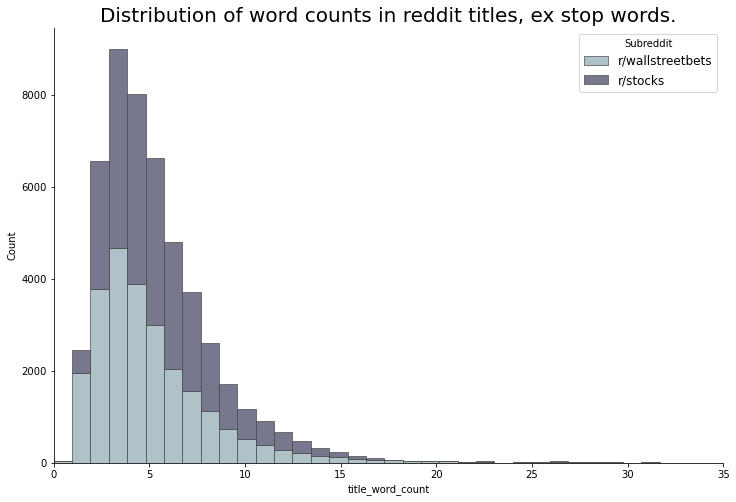

In [185]:
f, ax = plt.subplots(figsize=(12, 8))
sns.despine(f)

sns.histplot(
    df1,bins = 50,
    x="title_word_count", hue="subreddit",
    multiple="stack",
    palette="bone",
    edgecolor=".3",
    linewidth=.7,
    log_scale=False,
)
plt.xlim(0, 35);
plt.legend(title='Subreddit', loc='upper right', labels=['r/wallstreetbets', 'r/stocks'], fontsize = 'large');
plt.title('Distribution of word counts in reddit titles, ex stop words.', size = 20);

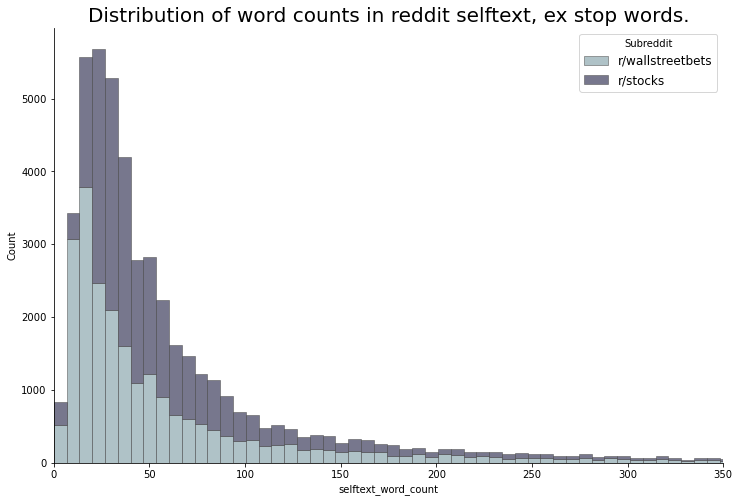

In [186]:
f, ax = plt.subplots(figsize=(12, 8))
sns.despine(f)

sns.histplot(
    df1, bins = 500,
    x="selftext_word_count", hue="subreddit",
    multiple="stack",
    palette="bone",
    edgecolor=".3",
    linewidth=.5,
    log_scale=False,
)
plt.xlim(0, 350)
plt.legend(title='Subreddit', loc='upper right', labels=['r/wallstreetbets', 'r/stocks'], fontsize = 'large');
plt.title('Distribution of word counts in reddit selftext, ex stop words.', size = 20);

# VADER 
---
I am investigating if we can make a good guess on origin of a post just by looking at their polarity.
Are posts from r/WallStreetBets more on the negative side as it's reputation indicates? If so, can I quantify this and then make good guesses based on polarity?

--The text being provided to VADER has been lowercased and reconfigured for lemmatizing prep. Punctuation was preserved, however, it is possible that it was over normalized when uppercase was removed and all contractions expanded.  


In [187]:
df_vader.head()

,subreddit,title,selftext,created_utc
0,wallstreetbets,help,i just sold my car for i want to know if can d...,1635955282
1,wallstreetbets,hyzn preparing for a squeeze…,hyzn still yet to recover from the weak short ...,1635955250
2,wallstreetbets,all in on meta,cut to the chase i am all in on meta here is w...,1635955106
3,wallstreetbets,camping world holdings moon discussion,beat on both the top and bottom line by a heal...,1635954989
4,wallstreetbets,camping world holdings moon discussion market cap,beat on both the top and bottom line by a heal...,1635954885


In [188]:
title_corp = list(df_vader['title'])

In [189]:
text_corp = list(df_vader['selftext'])

## Instantiate

In [190]:
sia = SentimentIntensityAnalyzer()

In [196]:
sia.polarity_scores(title_corp[5])

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [195]:
sia.polarity_scores(text_corp[5])

{'neg': 0.031, 'neu': 0.954, 'pos': 0.015, 'compound': -0.2732}

## Dataframe of Sentiment

In [213]:
sentiment = []    
for title in title_corp:
    scores = sia.polarity_scores(title)
    scores['title'] = title
    sentiment.append(scores)

title_sentiment = pd.DataFrame(sentiment)

In [214]:
title_sentiment.head(3)

,neg,neu,pos,compound,title
0,0.0,0.0,1.0,0.4019,help
1,0.0,1.0,0.0,0.0000,hyzn preparing for a squeeze…
2,0.0,1.0,0.0,0.0000,all in on meta


In [215]:
title_sentiment['subreddit'] = df1['subreddit']

In [230]:
sentiment = []    
for text in text_corp:
    scores = sia.polarity_scores(text)
    scores['selftext'] = text
    sentiment.append(scores)

text_sentiment = pd.DataFrame(sentiment)

In [231]:
text_sentiment['subreddit'] = df1['subreddit']

In [232]:
text_sentiment.tail(3)

,neg,neu,pos,compound,selftext,subreddit
49997,0.045,0.879,0.075,0.2960,i use chwab and apparently they use daily comp...,0
49998,0.027,0.927,0.046,0.3612,hello im importing portfolio data into yahoo f...,0
49999,0.122,0.824,0.054,-0.7717,i think about joseph kennedys famous hoeshiner...,0


In [233]:
merged_vader = pd.merge(title_sentiment, text_sentiment, how= 'inner', left_index=True, right_index=True)

In [234]:
merged_vader['subreddit'] = df1['subreddit']

## Polarities

We have three dataframes here to workwith: `title_sentiment` , `text_sentiment`, and `merged_vader`. I will only look at the first two. The third one may not be used, but it is created for convenience.  

### Title polarities

Text(0, 0.5, 'Subreddit')

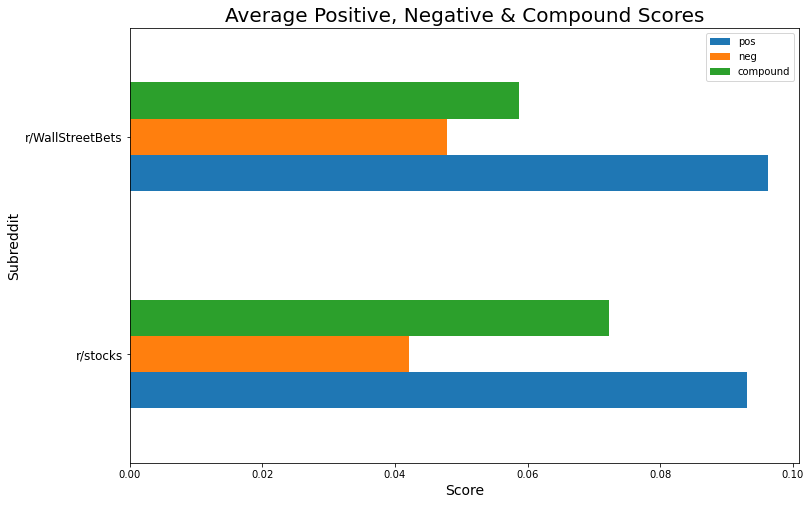

In [263]:

title_sentiment.groupby('subreddit').mean()[['pos', 'neg', 'compound']].plot(kind='barh', figsize = (12,8))
plt.title('Average Positive, Negative & Compound Scores', size = 20);
plt.yticks([0, 1], ['r/stocks', 'r/WallStreetBets'], size=12);
plt.xlabel('Score', size = 14)
plt.ylabel('Subreddit', size = 14)

In [264]:
title_sentiment.groupby('subreddit').mean()[['pos', 'neg', 'compound']]


,pos,neg,compound
subreddit,,,
0,0.093086,0.042171,0.072223
1,0.096190,0.047800,0.058764


### Text Polarities

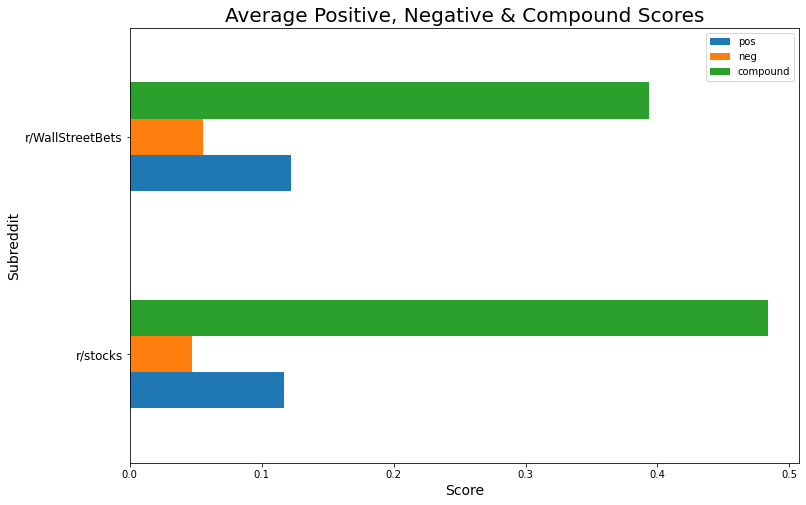

In [265]:
text_sentiment.groupby('subreddit').mean()[['pos', 'neg', 'compound']].plot(kind='barh', figsize = (12,8))

plt.title('Average Positive, Negative & Compound Scores', size = 20);
plt.yticks([0, 1], ['r/stocks', 'r/WallStreetBets'], size=12);
plt.xlabel('Score', size = 14);
plt.ylabel('Subreddit', size = 14);

In [239]:
text_sentiment.groupby('subreddit').mean()[['pos', 'neg', 'compound']]

,pos,neg,compound
subreddit,,,
0,0.117114,0.047402,0.483476
1,0.122059,0.055295,0.393712


---

# TF-IDF frequencies
I decided to use TF-IDF due to the volume of text and the similarities between the two subreddits. Here I will look at the word frequencies of uni-grams, bi-grams, tri-grams, and quad-grams. `max_features` set to 10% of the corpus data quantity; 5, 000


In [89]:
df_idf.head(3)

,subreddit,title,selftext,created_utc
0,wallstreetbets,help,i just sold my car for i wanna know if can do...,1635955282
1,wallstreetbets,hyzn preparing for a squeeze…,hyzn still yet to recover from the weak short ...,1635955250
2,wallstreetbets,all in on meta,cut to the chase i’m all in on meta here is ...,1635955106


In [ ]:
#split df_idf to two dfs by subreddit, WSB and stocks. 

In [91]:
df_wsb = df_idf[df_idf['subreddit'] == 'wallstreetbets'].copy()

In [92]:
df_stk = df_idf[df_idf['subreddit'] == 'stocks'].copy()

In [90]:
#set each XT variable for selftext, but one for wsb and the other for stocks. 

In [ ]:
#run the vectorizor again. 

In [56]:
XT_bi.head()

,aapl mft,able buy,able make,able pay,able sell,able use,accessible bar,according bloomberg,according data,according factet,...,youre looking,youre probably,youtube channel,youtube video,youtube videos,yoy growth,yoy increase,yoy revenue,ytd fridays,zero debt
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [115]:
tvec_uni = TfidfVectorizer(ngram_range=(1,1), stop_words = 'english', max_features = 50000, max_df = .90)
tvec_bi = TfidfVectorizer( ngram_range=(2,2), stop_words = 'english',max_features = 50000, max_df = .90)
tvec_tri = TfidfVectorizer( ngram_range=(3,3), stop_words = 'english',max_features = 50000, max_df = .90)
tvec_quad = TfidfVectorizer( ngram_range=(4,4), stop_words = 'english',max_features = 50000, max_df = .90)

## Title series
Each corpus is run through the vecotrizer for charter when completed. 

In [93]:
XT_w = df_wsb['selftext']

In [94]:
XT_stk = df_stk['selftext']

In [120]:
#XT_uni_wsb = pd.DataFrame(tvec_uni.fit_transform(XT_w).todense(), columns=tvec_uni.get_feature_names_out())
#XT_bi_wsb = pd.DataFrame(tvec_bi.fit_transform(XT_w).todense(), columns=tvec_bi.get_feature_names_out())
XT_tri_wsb = pd.DataFrame(tvec_tri.fit_transform(XT_w).todense(), columns=tvec_tri.get_feature_names_out())
#XT_quad_wsb = pd.DataFrame(tvec_quad.fit_transform(XT_w).todense(), columns=tvec_quad.get_feature_names_out())

In [121]:
#XT_uni_stk = pd.DataFrame(tvec_uni.fit_transform(XT_stk).todense(), columns=tvec_uni.get_feature_names_out())
#XT_bi_stk = pd.DataFrame(tvec_bi.fit_transform(XT_stk).todense(), columns=tvec_bi.get_feature_names_out())
XT_tri_stk = pd.DataFrame(tvec_tri.fit_transform(XT_stk).todense(), columns=tvec_tri.get_feature_names_out())
#XT_quad_stk = pd.DataFrame(tvec_quad.fit_transform(XT_stk).todense(), columns=tvec_quad.get_feature_names_out())

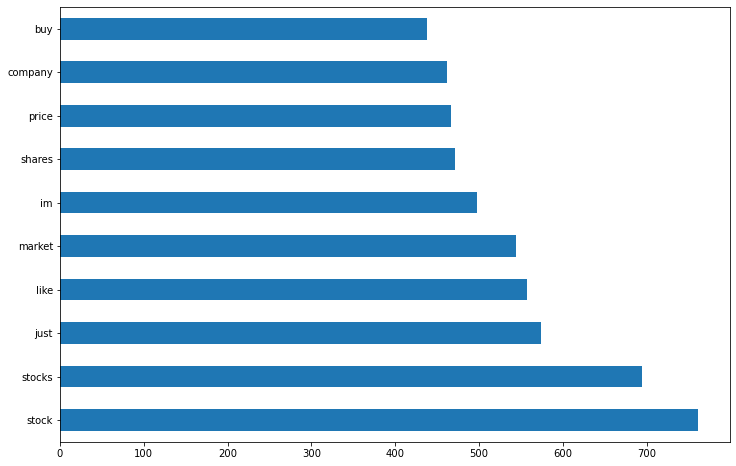

In [118]:
XT_uni_stk.sum().sort_values(ascending=False).head(10).plot(kind='barh', figsize = (12,8));

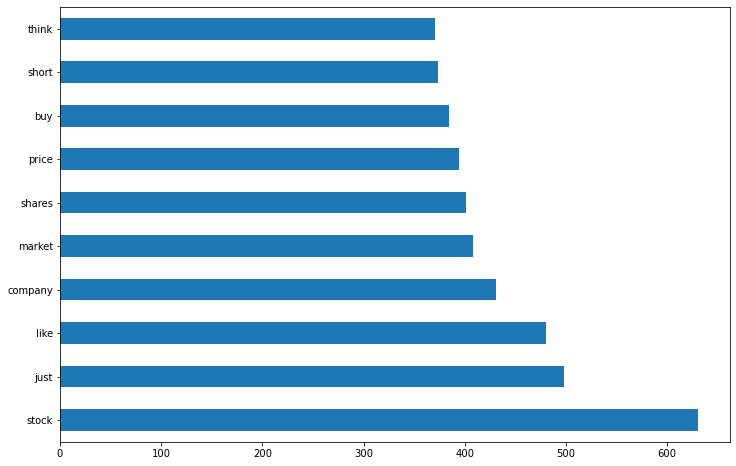

In [119]:
XT_uni_wsb.sum().sort_values(ascending=False).head(10).plot(kind='barh', figsize = (12,8));

<AxesSubplot:>

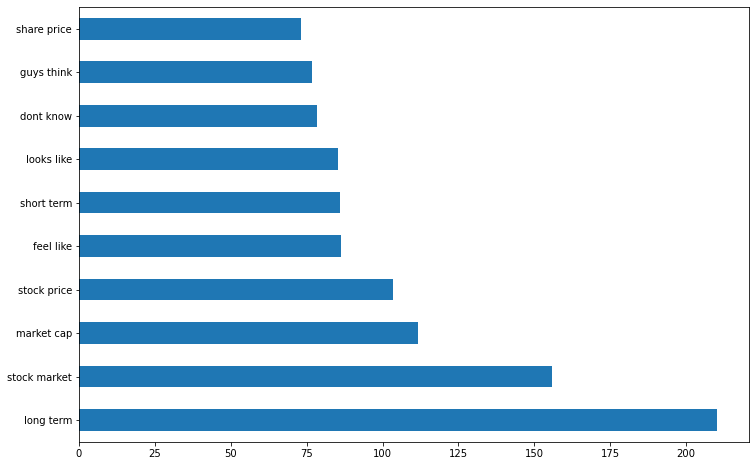

In [122]:
XT_bi_stk.sum().sort_values(ascending=False).head(10).plot(kind='barh', figsize = (12,8))

<AxesSubplot:>

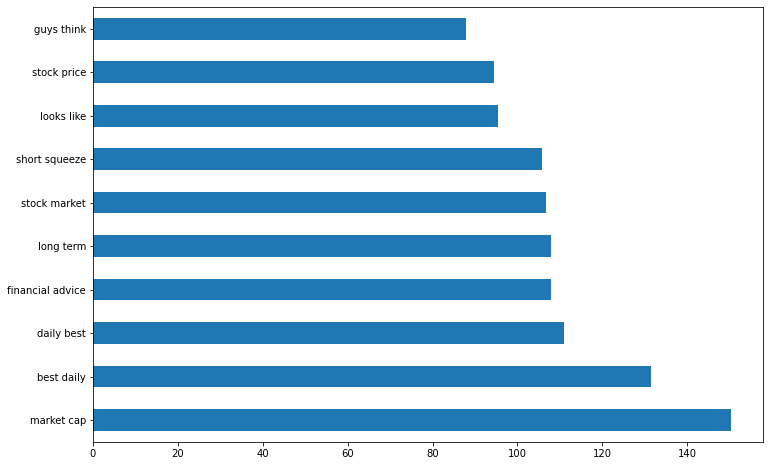

In [123]:
XT_bi_wsb.sum().sort_values(ascending=False).head(10).plot(kind='barh', figsize = (12,8))

<AxesSubplot:>

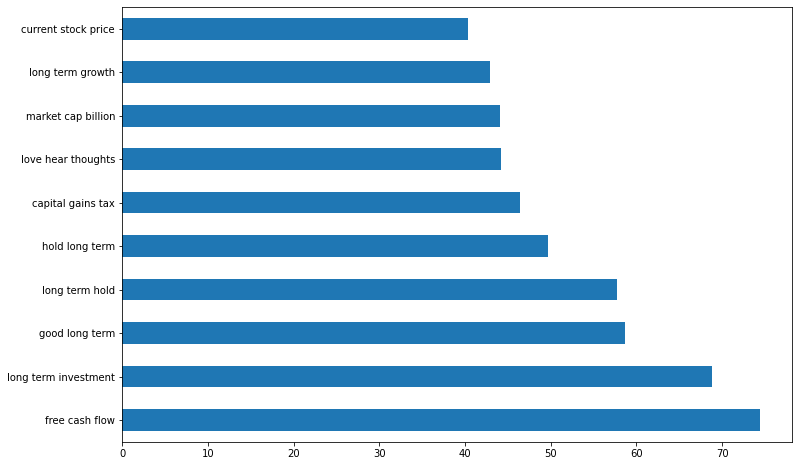

In [111]:
XT_tri_stk.sum().sort_values(ascending=False).head(10).plot(kind='barh', figsize = (12,8))

<AxesSubplot:>

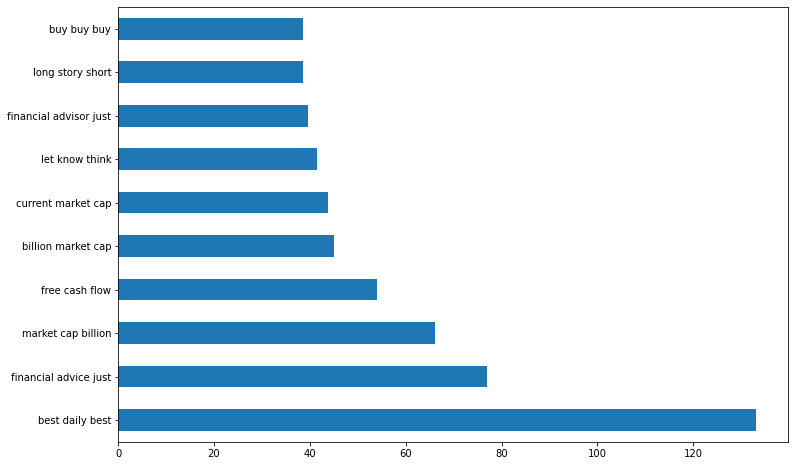

In [112]:
XT_tri_wsb.sum().sort_values(ascending=False).head(10).plot(kind='barh', figsize = (12,8))

<AxesSubplot:>

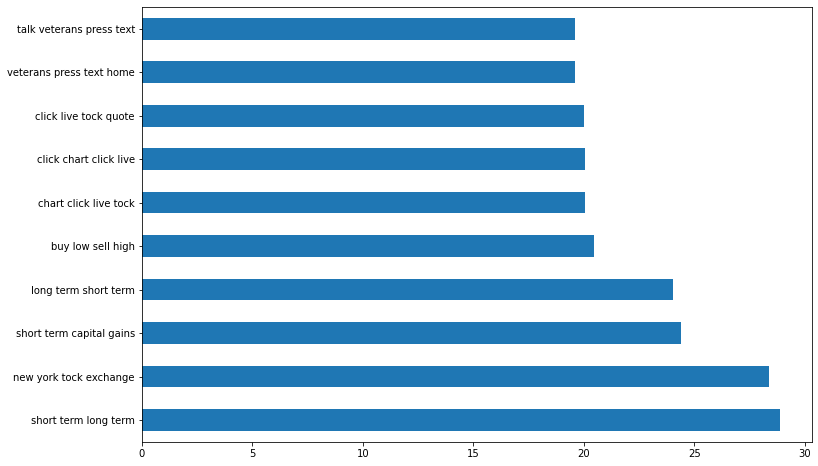

In [113]:
XT_quad_stk.sum().sort_values(ascending=False).head(10).plot(kind='barh', figsize = (12,8))

<AxesSubplot:>

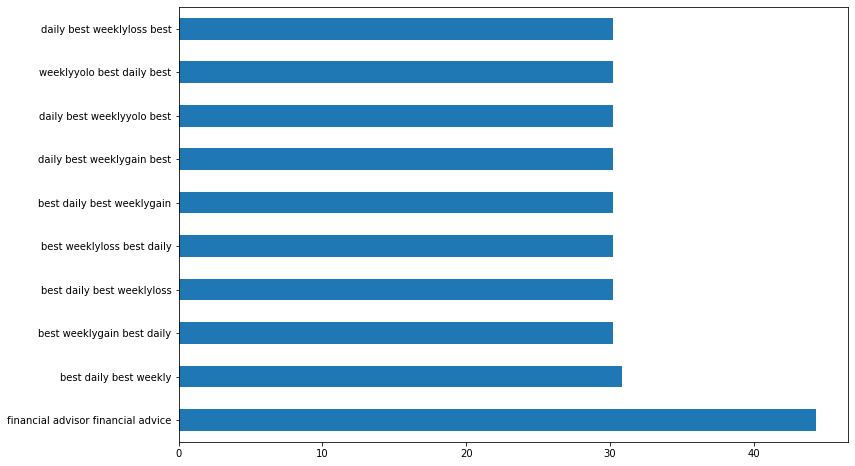

In [114]:
XT_quad_wsb.sum().sort_values(ascending=False).head(10).plot(kind='barh', figsize = (12,8))

In [100]:
#sns.barplot(data = title_top_10, hue = 'subreddit')

In [90]:
title_top_10 = XT_uni.sum().sort_values(ascending=False).head(10)

## Text series
Each corpus is run through the same way the title series was done. This takes a lot longer as the document size can vary from very small to very large (800+ words)

In [92]:
XT_uni.shape

(50000, 22753)

In [93]:
XT_uni.groupby('subreddit').sum().sort_values(by='subreddit', ascending = False).head(10).T

subreddit,1,0
aa,4.983165,8.738967
aaa,1.042527,0.467903
aaaaaaaaaahhhhhhhhhh,1.000000,0.000000
aaamn,0.000000,0.804700
aaarated,0.000000,0.433744
...,...,...
ᴾᴼⱽ,0.335077,0.000000
ᵒˡᵈ,0.335077,0.000000
ᶠᵘᶜᵏ,0.335077,0.000000
今日重点新闻看过来,0.654874,0.000000


# Final save of prepared data.
----


In [267]:
df1.to_csv('../data/reddit25k_processed.csv', index = False)
title_sentiment.to_csv('../data/titlesent.csv', index = False)
text_sentiment.to_csv('../data/textsent.csv', index = False)

In [1]:
print('send')

send
